# BTC REGRESSION PREDICTOR

Is it possible to use just raw price data to predict the upcoming price of bitcoin? That is the question I am looking to answer in this notebook. The plan is<br>
to try calculate features from only the date, high, low, open, close and volume for the last 1000 days of price action.

In [1]:
# Import statements

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

In [2]:
# Load our csv as a pandas dataframe
btc = pd.read_csv("BTCUSDT-D.csv")

In [3]:
# Have a squizz at the data
btc.head()

,date,time,open,high,low,close,volume
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382


We have to clean the date column up and split the string apart to only contain the day of the week as my idea is to use that to find a potential pattern <br>
in the price. I think that month in collaboration with day of the week might be handy too but im unsure... So for now we will just try day of the week and <br>
keep months in our back pocket

## Transform the data column, creating features

#### Adding days of the week

In [10]:
# Create a list to hold the days of the week
days = []

# Iterate over each date in the data column
for date in btc["date"]:
    # Split the string on the hypphens and take the first string (The abbrivated day)
    day = date.split("-")[0]
    # append the day to the list
    days.append(day)

# Create the new column for our dataframe containing the days of the week
btc["day"] = days
btc.head()

,date,time,open,high,low,close,volume,day
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon


### Calculate features

In [13]:
# Creates a list out of a given column

def create_list(column):
    """
    Takes a pandas column and iterates over it's content appending each
    row to a list and than returns that list
    :Params: coloumn - a pandas column
    :Return: ls - a list of all values in that column
    """
    
    ls = []
    
    for row in column:
        ls.append(row)
    return ls

#### Calculating percentage change

In [16]:
# Createa list of all open values
opens = btc["open"]

# Create a list of all close values
closes = btc["close"]


# Iterate through both lists of values and calculate the change from open to close price, append it to a list
changes = []
for idx in range(len(opens)):
    change = round((closes[idx] - opens[idx]) / opens[idx] * 100, 2)
    changes.append(change)

# Add the column to the data
btc["change"] = changes
btc.head()

,date,time,open,high,low,close,volume,day,change
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11


#### Calculating high to low differences

In [19]:
# Creates lists for the highs and the lows
highs = create_list(btc["high"])
lows = create_list(btc["low"])

# Create two features calculating the difference between the highs and the lows and the closes
high_to_close = []
low_to_close = []
high_to_low = []
for idx in range(len(closes)):
    high_to_close.append(round((highs[idx] - closes[idx]) / closes[idx] * 100, 2))
    low_to_close.append(round((closes[idx] - lows[idx]) / closes[idx] * 100, 2))
    high_to_low.append(round((highs[idx] - lows[idx]) / highs[idx] * 100, 2))
    
# Add our new features to the dataframe
btc["high_to_close"] = high_to_close
btc["low_to_close"] = low_to_close
btc["high_to_low"] = high_to_low
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18


#### Adding long an short labels

In [22]:
directions = []

for row in changes:
    if row >= 0:
        directions.append("long")
    else: 
        directions.append("short")

btc["direction"] = directions
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18,short


#### Creating a new dataframe on a subset of features

In [25]:
# Creating a smaller dataframe out of only a few features to test some ideas on
btc_features = btc.drop(["date", "time", "open", "high", "low", "close"], axis = 1)
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short


For now we have calculated only the day to day change, and the difference in the daily high and low from the close. I'm very skeptical of how this <br>
is going to work, so I first just want to see if I can get any results before putting anymore effort into this idea. I made a smaller subset of <br>
features in a new dataframe, lets go ahead and run through some workflow with them.

## Machine Learning/Big Data/Python/Collaboration..... workflow

In [29]:
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [31]:
# Transform our days using a labelencoder
day_encoder = LabelEncoder()
days = day_encoder.fit_transform(btc_features["day"])

dir_encoder = LabelEncoder()
direction = dir_encoder.fit_transform(btc_features["direction"])

# dir_encoder.classes_
btc_features["days"] = days
# btc_features.head()

In [126]:
# drop all features we don't want in our X set of data
X = btc_features.drop(["day", "change", "direction"], axis = 1)
X.head()

,volume,high_to_close,low_to_close,high_to_low,days
0,2246508966,1.26,5.44,6.61,4
1,1837726929,2.35,0.75,3.04,0
2,1147589024,1.47,0.61,2.05,2
3,1676805639,1.05,2.92,3.92,3
4,1765283382,2.79,0.48,3.18,1


In [35]:
# Split the testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, direction)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check it was transformed into an array by proxy of data scaling
# X_train

In [37]:
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

rnd_score = cross_val_score(rnd_clf, X_train, y_train, cv = 10, scoring="f1_macro").mean()
print(rnd_score)

knn_score = cross_val_score(knn_clf, X_train, y_train, cv = 10, scoring="f1_macro").mean()
print(knn_score)


0.7821102472355951
0.7956709044326205


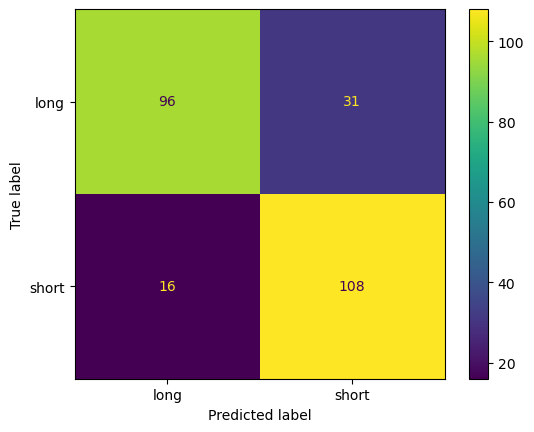

In [38]:
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
f1_score(y_test, y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels= dir_encoder.classes_)


In [124]:
y_pred = rnd_clf.predict([[]])
y_pred

array([0])

In [40]:
for name, score in zip(X.columns, rnd_clf.feature_importances_):
    print(name, score)

volume 0.13971828558246724
high_to_close 0.3269954140814215
low_to_close 0.32948884657132727
high_to_low 0.15333508210541735
days 0.05046237165936677


From the above two scores.... it's pretty plain to see that so far it not able to predict the correct day of the week give the volume and a few other <br>
features we've created. Why are we classifying on what should probably be a regression problem? Well if we can classify which day of the week it is <br>
when given price data, than technically we can reverse engineer and get the likely close (% up or down) given a day of the week. But so far no luck <br>
I'll go for a shower and ponder what we could change before bringing in outside factors.

In [58]:
rnd_reg = RandomForestRegressor()

score = cross_val_score(rnd_reg, X_train, y_train, scoring = "neg_mean_squared_error")
score.mean()
# import sklearn
# sklearn.metrics.get_scorer_names()

-0.15530746666666667

In [423]:
# TODO - plot out a histogram with days on the x axis and average scores on the y axis

In [62]:
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [122]:
change = 0
high = 0
low = 0
mag = 0
vol = 0
divisor = 0

days = set()
for day in btc["day"]:
    days.add(day)

# print(days)

for day in days:
    for row in range(len(btc)):
        if btc["day"][row] == day:
            change += btc["change"][row]
            high += btc["high_to_close"][row]
            low += btc["low_to_close"][row]
            mag += btc["high_to_low"][row]
            vol += btc["volume"][row]
            divisor += 1

    print(f"{day} change: {round(change / divisor,4)}\tHigh: {round(high / divisor,4)}\tLow: {round(low / divisor,4)}\tMag: {round(mag / divisor,4)}\tVolume: {round(vol / divisor,4)}")

Thu change: -0.1241	High: 2.3789	Low: 2.2858	Mag 4.522	Volume: 5270367101.3427
Sat change: -0.0572	High: 1.8033	Low: 1.7799	Mag 3.4857	Volume: 3876026091.4685
Sun change: -0.0052	High: 1.7223	Low: 1.6905	Mag 3.3285	Volume: 3544710919.4079
Tue change: -0.0004	High: 1.864	Low: 1.8498	Mag 3.6138	Volume: 4066545092.8881
Wed change: 0.0252	High: 1.987	Low: 1.976	Mag 3.8523	Volume: 4398466697.5189
Mon change: 0.0866	High: 2.0433	Low: 2.1052	Mag 4.0285	Volume: 4586073264.8298
Fri change: 0.063	High: 2.0854	Low: 2.1468	Mag 4.1092	Volume: 4693498225.9171


In [138]:
y_pred = rnd_clf.predict([[0, 2.3789, 2.2858, 0, 8]])
y_pred
# day_encoder.classes_

array([1])